In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode, entropy
from datetime import datetime, timedelta
from collections import defaultdict
from pprint import pprint
import time, json, os

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LassoLarsIC
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score

pd.set_option('display.max_columns', None)
os.chdir('/Users/meif/Desktop/SI 699')
import matplotlib.pyplot as plt

% matplotlib inline 

This notebook is to use AIC to do the feature selection.

## 0. Prepare Dataset

In [2]:
# continuous and categorical
mains = ["user_coupon", "user_id", "coupon_id", "start_time", "is_used"]

categorical = ['sex_1', 'sex_2', 
               'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 
               'city1', 'city2', 'city3', 'city4', 'city5', 
               'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8',
               'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 
               'type1', 'type6', 
               'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 
               'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', 
               '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀',
               'CoupUseLast']

conitnuous = ['kitchen_entropy', 
              'distance_median', 'distance_std',
              'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 
              'coupon_effective_days', 'money', 'max_money', 
              'WeeklyCouponUsedCount', "BiWeeklyCouponUsedCount",
              'WeeklyOrderCount', 'BiWeeklyOrderCount',
              'coupon_usage_rate', 'order_coupon_usage_rate',
              'coupon_type1_usage_rate', 'coupon_type6_usage_rate',
              'coupon_used_weekend_perc', 'order_weekend_perc', 
              'worth_money_median', 'worth_money_std', 
              'InterCoup', 'InterOrder', 'Recency']

In [3]:
trainset = pd.read_csv("Dataset/trainset_180314.csv").iloc[:,1:]
print(len(trainset))
print(trainset.columns[5:].tolist())

4422530
['sex_1', 'sex_2', 'age_60', 'age_70', 'age_80', 'age_90', 'age_0', 'city1', 'city2', 'city3', 'city4', 'city5', 'AppVerLast_2.1', 'AppVerLast_2.2', 'AppVerLast_2.3', 'AppVerLast_2.4', 'AppVerLast_2.5', 'AppVerLast_2.7', 'AppVerLast_2.8', 'kitchen_entropy', 'distance_median', 'distance_std', 'user_longitude_median', 'user_longitude_std', 'user_latitude_median', 'user_latitude_std', 'coupon_effective_days', 'money', 'max_money', 'covers_mon', 'covers_tue', 'covers_wed', 'covers_thu', 'covers_fri', 'covers_sat', 'covers_sun', 'type1', 'type6', 'Complaints', 'Eventsoperation', 'NewUserCouponPackageByBD', 'PreUserCouponCode', 'RecallUserDaily', 'home201603222253', 'home_dongbeiguan', 'home_jiangzhecai', 'home_muqinjie', 'home_xiangcaiguan', 'preuser', 'shareuser', '商家拒单返券', '家厨发券', '活动赠券', '码兑券', '自运营赠券', '蒲公英受邀', 'coupon_usage_rate', 'order_coupon_usage_rate', 'coupon_type1_usage_rate', 'coupon_type6_usage_rate', 'coupon_used_weekend_perc', 'order_weekend_perc', 'worth_money_media

## 1. AIC Selection

In [4]:
selected_linear_aic = {}
SCALERS = ["MinMax", "Stdard", "MaxAbs", "Robust"]
for s in SCALERS:
    selected_linear_aic[s] = []
selected_linear_aic

{'MaxAbs': [], 'MinMax': [], 'Robust': [], 'Stdard': []}

In [ ]:
# train
start_time = time.time()

for i in SCALERS:
    start_time1 = time.time()
    
    if i == "MinMax":
        scaler = MinMaxScaler()
    elif i == "Stdard":
        scaler = StandardScaler()
    elif i == "MaxAbs":
        scaler = MaxAbsScaler()
    elif i == "Robust":
        scaler = RobustScaler()

    print("scaling...")
    X_train_continuous = scaler.fit_transform(trainset[conitnuous])
    trainset_scaled = pd.concat([trainset.loc[:,mains + categorical], pd.DataFrame(X_train_continuous, columns = conitnuous)], axis=1)
    
    print("shuffling...")
    trainset_all = trainset_scaled
    trainset_all = trainset_all.iloc[shuffle(trainset_all.index).tolist(),]
    X_train_all = trainset_all.iloc[:,5:]
    y_train_all = trainset_all["is_used"]
    
    print("fitting...")
    reg = LassoLarsIC(criterion='aic', normalize=False)
    reg.fit(X_train_all, y_train_all)
    selected_linear_aic[i] = str(reg.coef_)
    
    print("After {} scaler, {} sec\n".format(i, time.time() - start_time1))
    
print("{} sec\n".format(time.time() - start_time))

scaling...
shuffling...
fitting...
After MaxAbs scaler, 135.0668740272522 sec

scaling...


In [12]:
# save param output
with open('ParamResults/LinearModels/other/selected_linear_aic.json', 'w') as f:
    json.dump(selected_linear_aic, f)

# 2. Evaluation

In [65]:
# load params
selected_linear_aic = json.load(open("ParamResults/LinearModels/other/selected_linear_aic.json"))
SCALERS = ["MinMax", "Stdard", "MaxAbs", "Robust"]
for s in SCALERS:
    selected_linear_aic[s] = selected_linear_aic[s].split()
    selected_linear_aic[s].pop(0)
    selected_linear_aic[s][-1] = selected_linear_aic[s][-1][:-1]
    selected_linear_aic[s] = np.array([float(i) for i in selected_linear_aic[s]])

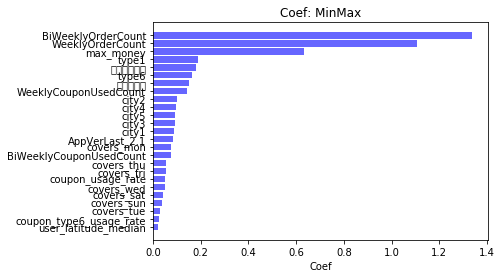

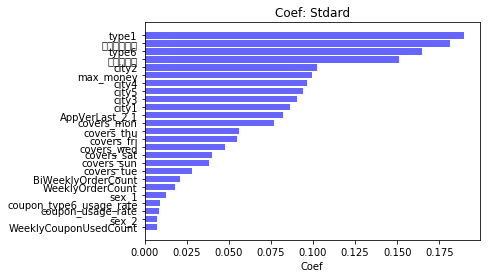

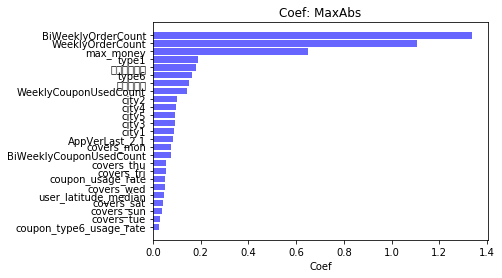

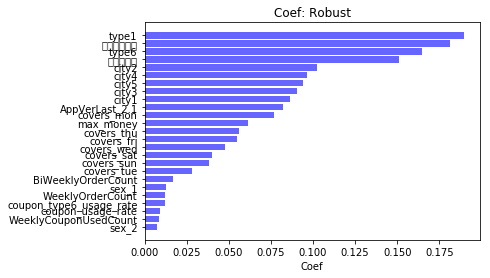

In [66]:
k = 25
features = X_train_all.columns
for s in SCALERS:
    coefs = selected_linear_aic[s]
    indices = np.argsort(coefs)
    
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.set_title('Coef: {}'.format(s))
    ax.barh(range(k), coefs[indices[-k:]], color='#6666FF', align='center')
    ax.set_yticks(range(k))
    ax.set_yticklabels(features[indices[-k:]])
    ax.set_xlabel('Coef')
    plt.savefig('ParamResults/LinearModels/other/selected_linear_aic_{}.png'.format(s))
    plt.show()